In [1]:
import numpy as np
import healpy as hp
import os
import fitsio
import lusee
import scipy.linalg as la
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
freq =np.arange(1,51)
DA = lusee.mono_sky_models.T_DarkAges(freq) 

# Basic Eigen stuff

In [3]:
m = fitsio.read(os.environ['LUSEE_DRIVE_DIR']+'/Simulations/SkyModels/ULSA_32_ddi_smooth.fits')
Nside=32
Npix = Nside**2*12
theta,_=hp.pixelfunc.pix2ang(Nside,np.arange(Npix))
wg=np.where(np.abs(theta-np.pi/2)<0.25)
w=np.where(np.abs(theta-np.pi/2)>0.30)

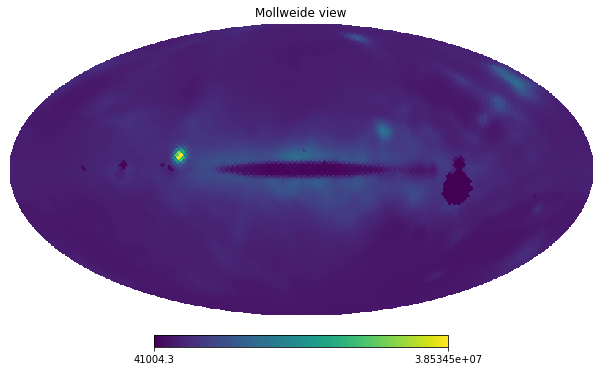

In [4]:
pm=np.copy(m[3])
#pm[wg]=np.nan
hp.mollview(pm)

In [5]:
we = (freq/10)**2.5
sk = m[:,w[0]]*we[:,None]
C = np.cov(sk)
eva,eve = la.eig(C)
eva,eve = np.real(eva),np.real(eve)

In [6]:
def rmc (data, vec):
    datao = np.copy(data)
    for v in vec:
        datao -=  np.dot(datao,v)/np.dot(v,v)*v
    return datao

[]

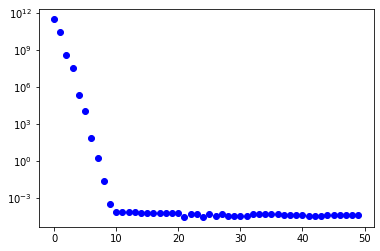

In [7]:
plt.plot(eva,'bo')
plt.semilogy()

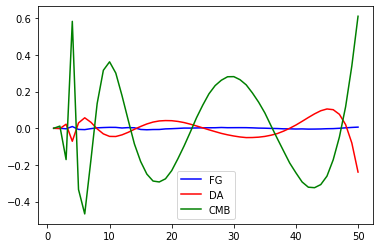

In [8]:
fg = sk.mean(axis=1)
plt.plot(freq,rmc(fg,eve[:,:9].T),'b-',label='FG')
plt.plot(freq,rmc(DA*we,eve[:,:9].T),'r-',label='DA')
plt.plot(freq,rmc(2.73*np.ones_like(freq)*we,eve[:,:9].T),'g-',label='CMB')
plt.legend()

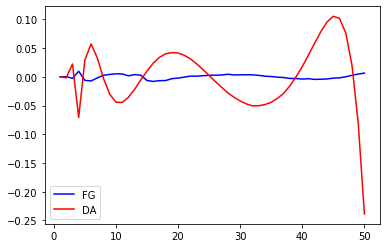

In [9]:
# Can we do some clever weighting
MN=9
owfg = np.zeros(len(freq))
sw = 0
vl=[]
for sightline in sk.T:
    var = (rmc(sightline,eve[:,MN:].T)**2*DA**2).sum()
    owfg += 1/var *sightline
    sw += 1/var
    vl.append(var)

#plt.hist(vl);stop()
owfg = owfg/sw
plt.plot(freq,rmc(owfg,eve[:,:MN].T),'b-',label='FG')
plt.plot(freq,rmc(DA*we,eve[:,:MN].T),'r-',label='DA')
#plt.plot(freq,rmc(2.73*np.ones_like(freq)*we,eve[:,:MN].T),'g-',label='CMB')
plt.legend()
    
    

# Forcing eigenvectors to be orthogonal to DA (doesn't work)

[]

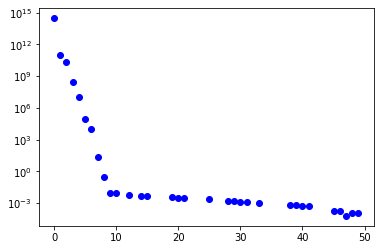

In [10]:
eva,eve = la.eig(C+1e16*np.outer(DA,DA))
eva,eve = np.real(eva),np.real(eve)
plt.plot(eva,'bo')
plt.semilogy()

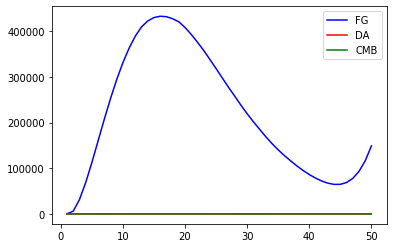

In [11]:
fg = sk.mean(axis=1)
plt.plot(freq,rmc(fg,eve[:,1:9].T),'b-',label='FG')
plt.plot(freq,rmc(DA*we,eve[:,1:9].T),'r-',label='DA')
plt.plot(freq,rmc(2.73*np.ones_like(freq)*we,eve[:,1:9].T),'g-',label='CMB')
plt.legend()

In [12]:
from scipy.stats import norm
l,l2=[],[]

for i,fd in enumerate(m[:,w[0]]):
    lfd = np.log(fd)
    lfd2 = np.log(fd+DA[i])
    h,e=np.histogram(lfd,bins=200)
    de=e[1]-e[0]
    c = np.hstack((0,np.cumsum(h)/len(fd)))
    e = np.hstack((e[0]-de,e[1:-1],e[-1]+de))
    nfd=interp1d(e,c,'linear')(lfd) 
    nfd2=interp1d(e,c,'linear')(lfd2) 
    g = norm.ppf(nfd)
    g2 = norm.ppf(nfd2)
    if any(np.isnan(g)):
        print (nfd[np.isnan(g)])
        stop()
    l.append(g)
    l2.append(g2)
    
l=np.array(l)   
l2=np.array(l2)    
                  
    

(array([  2.,   2.,   5.,   5.,  13.,  20.,  30.,  48.,  77., 111., 140.,
        216., 265., 335., 413., 476., 560., 584., 646., 640., 629., 606.,
        553., 483., 412., 350., 273., 207., 155., 110.,  76.,  52.,  34.,
         20.,  13.,   7.,   4.,   2.,   1.,   1.]),
 array([-3.68002733, -3.49169772, -3.30336811, -3.11503849, -2.92670888,
        -2.73837927, -2.55004965, -2.36172004, -2.17339043, -1.98506081,
        -1.7967312 , -1.60840159, -1.42007198, -1.23174236, -1.04341275,
        -0.85508314, -0.66675352, -0.47842391, -0.2900943 , -0.10176468,
         0.08656493,  0.27489454,  0.46322416,  0.65155377,  0.83988338,
         1.028213  ,  1.21654261,  1.40487222,  1.59320183,  1.78153145,
         1.96986106,  2.15819067,  2.34652029,  2.5348499 ,  2.72317951,
         2.91150913,  3.09983874,  3.28816835,  3.47649797,  3.66482758,
         3.85315719]),
 <BarContainer object of 40 artists>)

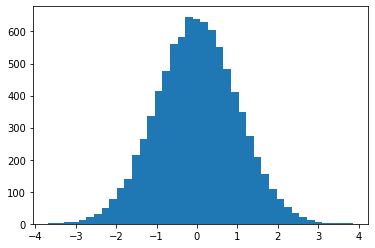

In [13]:
plt.hist(l[4,:],bins=40)

In [14]:
C = np.cov(l)
eva,eve = la.eig(C)
eva,eve = np.real(eva),np.real(eve)

[]

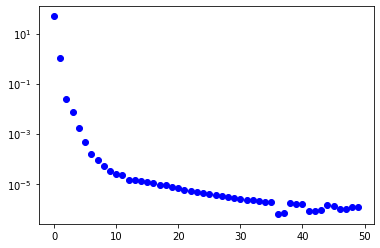

In [15]:
plt.plot(eva,'bo')
plt.semilogy()